This notebook looks at $\sigma_t$ surfaces around JdFE region.

In [2]:
import ACTDR
import TSmode
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import calendar
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
import pickle
import seawater as SW

%matplotlib inline

In [3]:
# this is for plotting stuff
sns.set()
sns.set_style('darkgrid')
sns.set_context('poster')

In [4]:
# loading in the global data
ACTDR.reset_global()
ACTDR.load_dat('DB_v02.dat')

#wcvi_top = TSmode.get_topo()
wcvi_top = pickle.load(open('topo.p','rb'))

> open  DB_v02.dat
> load CTD_DAT
> load STANDARD_KEYS
> close  DB_v02.dat
> complete


In [176]:
# this part filters the casts used
LONrng=[-126,-124.4]
LATrng=[47.9,49]

# note that the region is being increased by 1 degree in each direction -- this is so 
# we can use the casts outside of the field of interest to generate our interpolated maps
filt_csts = TSmode.filter_CTD_list('REGION',[LONrng[0]-1,LATrng[0]-1],[LONrng[1]+1,LATrng[1]+1])

In [188]:
# get some statistics about the cast distribution in time 
from collections import Counter

for ii in range(1,13):
    print calendar.month_name[ii], ' : ', len([k for k in filt_csts if k['Month'] == ii])
    
    a = Counter([k['Year'] for k in filt_csts if k['Month'] == ii])
    print 'Most common years :', a.most_common()

January  :  810
Most common years : [(1978, 75), (2002, 63), (1979, 61), (2001, 58), (1999, 51), (1986, 44), (1981, 41), (1974, 37), (1980, 32), (1971, 28), (1970, 26), (1990, 22), (1992, 21), (1975, 18), (1977, 18), (1985, 18), (1987, 17), (1989, 17), (1973, 16), (1983, 16), (1984, 16), (1982, 13), (1991, 13), (1972, 12), (1988, 10), (1993, 10), (1976, 9), (2004, 8), (2006, 7), (1998, 6), (2009, 6), (1997, 5), (2003, 5), (2000, 4), (1995, 2), (1996, 2), (2005, 2), (2008, 1)]
February  :  1254
Most common years : [(1981, 93), (1987, 88), (1980, 85), (1988, 81), (1986, 67), (1979, 63), (1991, 50), (1977, 49), (1990, 45), (1997, 39), (2003, 37), (1998, 36), (2002, 36), (1972, 31), (1992, 31), (2004, 31), (1973, 30), (1970, 28), (1996, 28), (1976, 27), (1971, 25), (1974, 22), (1985, 22), (2005, 22), (1984, 19), (1978, 18), (2009, 17), (1989, 16), (1983, 15), (1975, 14), (2006, 14), (2007, 14), (1999, 12), (2001, 12), (1993, 9), (1982, 7), (1995, 6), (1994, 5), (2008, 5), (2000, 4), (2013,

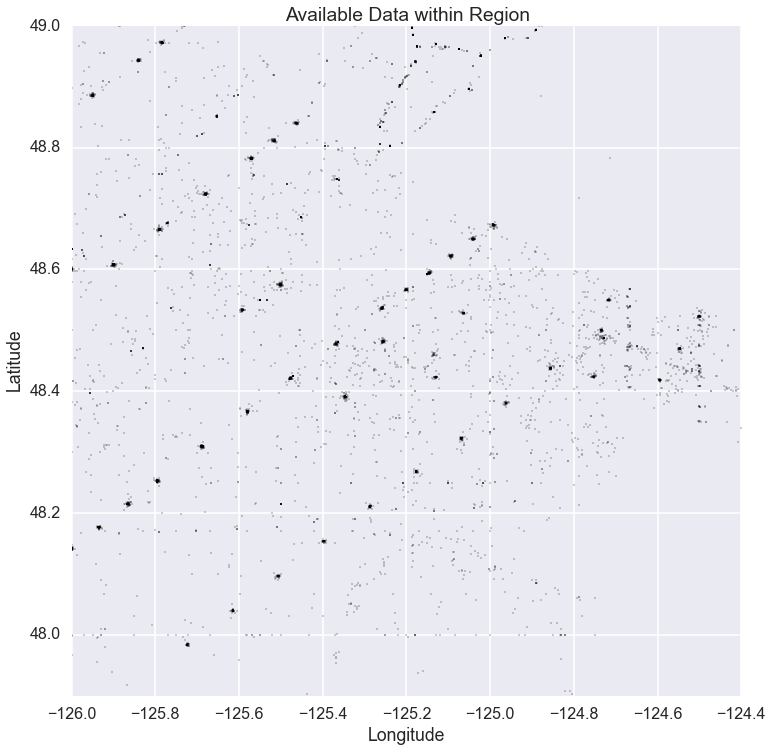

In [35]:
plt.figure(figsize=(12,12))
plt.plot([k['Longitude'] for k in filt_csts],[k['Latitude'] for k in filt_csts],'.k',ms=2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Available Data within Region')
plt.xlim(LONrng)
plt.ylim(LATrng)
plt.show()

In [36]:
# setup the Juan de Fuca eddy region and cast list
JdFE_lon = [-125.6,-124.8]
JdFE_lat = [48.2,48.6]

JdFE_csts = TSmode.filter_CTD_list('REGION',[JdFE_lon[0],JdFE_lat[0]],[JdFE_lon[1],JdFE_lat[1]])

In [190]:
# define a function to generated and draw an interpolated surface
def draw_surface(surf_type,cast_inf,dpth,varnm,col_lim=(0,0),cmap = 'Spectral_r',show_cbar = True):
    '''
    draw surface
    Generates and plots an interpolated surface. There are two types of surfaces, specified by surf_type
    surf_type -- a string argument
    'DEPTH' -- a surface generated based on a specific depth (e.g. 50 meters would be surf_type='DEPTH', dpth=50)
    'ISOPYC' -- a surface generated based on a specific sigma-t value (e.g. 26 kg m^-3 would be surf_type='ISOPYC', dpth=26)
    
    cast_inf -- the cast list which to use to generate the surface
    
    dpth -- the corresponding depth/isopycnal to use to generate the surface
    
    varnm -- the variable of interest (e.g. Salinity, Temperature, Depth, sigmaT, etc.)
    
    col_lim -- the colorbar limits, if not specified, will use the minimum and maximum of data
    
    cmap -- specifies the colormap, optional
    
    show_cbar -- specifies whether the colorbar should be shown or note, default is True
    '''
    
    # determines the interpolated grid size
    N = 25
    
    # generate surface based on argument
    if surf_type == 'DEPTH':
        (lon_region,lat_region,grid_dat,tmp) = TSmode.get_depth_surface(cast_inf,dpth,varnm,LONrng,LATrng,Nlon=N,Nlat=N,interp='linear')
    else:
        (lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(cast_inf,dpth,varnm,LONrng,LATrng,Nlon=N,Nlat=N,interp='linear')
    
    # check if color lim is set manually or automatically
    if col_lim == (0,0):
        col_lim = (np.nanmin(grid_dat),np.nanmax(grid_dat))
    
    # if grid data is outside of the limits, set it to the limits for plotting purposes
    grid_dat[grid_dat>col_lim[1]] = col_lim[1]
    grid_dat[grid_dat<col_lim[0]] = col_lim[0]
    
    # there are three plotting types I have here
    
    # 1. this one is default, plots a filled contour map with 50 contours
    # -- preferred over pcolor because it skips over nan values and doesn't plot outside of interpolated zone
    im = plt.contourf(lon_region,lat_region,grid_dat,np.linspace(col_lim[0],col_lim[1],50),cmap=cmap)
    
    # 2. this one plots solid black contour lines 
    ####im = plt.contour(lon_region,lat_region,grid_dat,np.linspace(col_lim[0],col_lim[1],5,endpoint=True),colors='k')
    
    # 3. this on plots the data as a pixel color plot -- might look better/more exact, but nan values, or extraneous values
    # are plotted as the "minimum" value
    ####im = plt.pcolor(lon_region,lat_region,grid_dat,cmap=cmap)
    
    # need to uncomment this if using pcolor
    #plt.clim(col_lim)
    
    # if we have a colorbar, show it
    if show_cbar:
        plt.colorbar()
    
    # plot the JdFE region box
    plt.plot([JdFE_lon[0],JdFE_lon[1],JdFE_lon[1],JdFE_lon[0],JdFE_lon[0]],[JdFE_lat[0],JdFE_lat[0],JdFE_lat[1],JdFE_lat[1],JdFE_lat[0]],'-k',lw=4,alpha=0.7)
    plt.plot([JdFE_lon[0],JdFE_lon[1],JdFE_lon[1],JdFE_lon[0],JdFE_lon[0]],[JdFE_lat[0],JdFE_lat[0],JdFE_lat[1],JdFE_lat[1],JdFE_lat[0]],'-w',lw=2,alpha=0.9)
        
    # plot the land/ isobaths
    plt.contour(wcvi_top['lons'],wcvi_top['lats'],wcvi_top['topo'],[-200,-100,0],colors=[0.7,0.7,0.7],linewidths=1)
    plt.contourf(np.fliplr(wcvi_top['lons']),np.fliplr(wcvi_top['lats']),np.fliplr(wcvi_top['topo']),[0,5000],colors='k',lw=2)
    
    # set the ticks to only show extreme values (otherwise it's too cluttered)
    plt.xticks(LONrng,[str(LONrng[0]),str(LONrng[1])])
    plt.yticks(LATrng,[str(LATrng[0]),str(LATrng[1])])
    
    # uncomment this to show each cast used as a small dot on the map
    #plt.plot([k['Longitude'] for k in cast_inf],[k['Latitude'] for k in cast_inf],'.k',ms=4)
    
    # set the x and y limits
    plt.xlim(LONrng)
    plt.ylim(LATrng)
    
    # return the contour image handle
    return im

> using  327  cast data
> using  617  cast data
> using  689  cast data
> using  1104  cast data
> using  1805  cast data
> using  1556  cast data
> using  1549  cast data
> using  1527  cast data
> using  1379  cast data
> using  1597  cast data
> using  645  cast data
> using  288  cast data


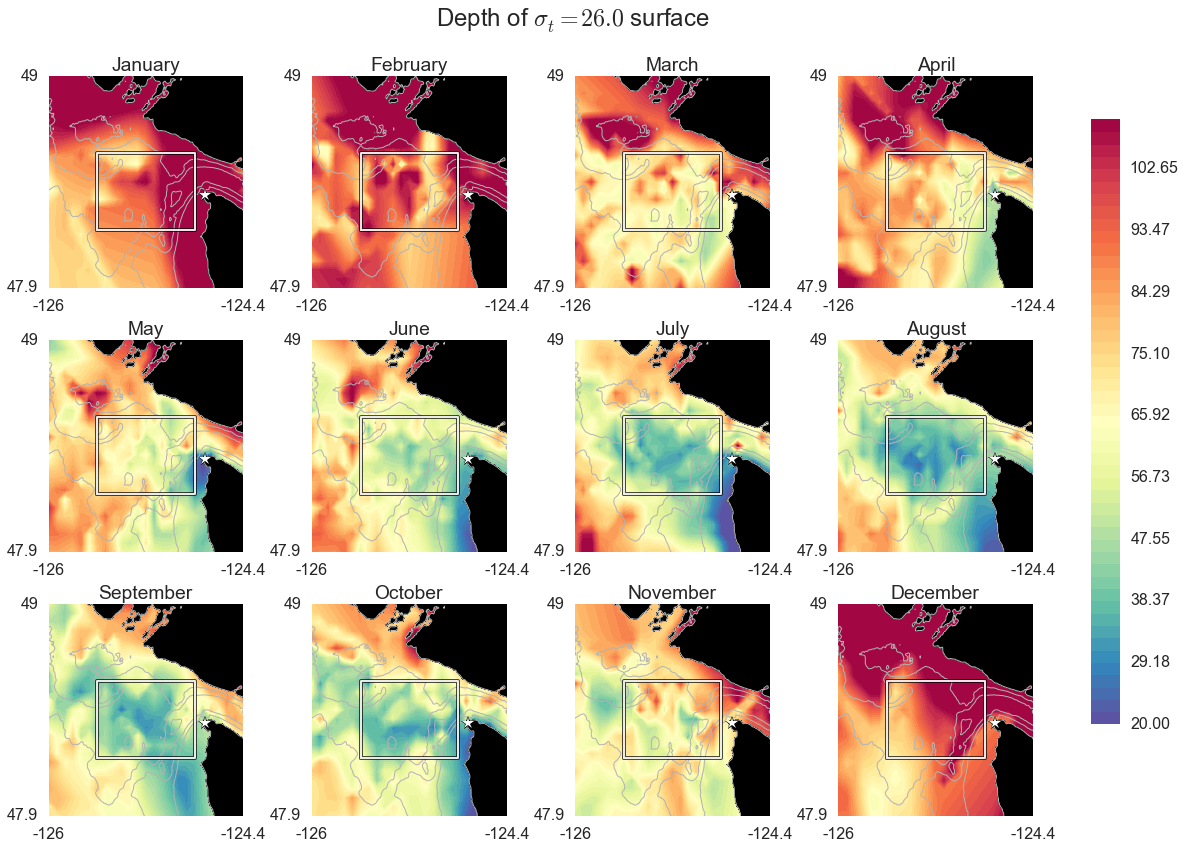

In [187]:
reload(TSmode)
fig = plt.figure(figsize=(16,12))

for ii in range(1,13):
    plt.subplot(3,4,ii)
    im = draw_surface('ISOPYC',[k for k in filt_csts if k['Month'] == ii],26,'Depth',col_lim=(20,110),cmap='Spectral_r',show_cbar=False)
    
    # plots the position of Cape Flattery as a white star with a black outline
    plt.plot(-124.714,48.3831,'*k',ms=15)
    plt.plot(-124.714,48.3831,'*w',ms=12)
    plt.title(calendar.month_name[ii])

# housekeeping stuff to make the plot look nice
plt.tight_layout()
fig.subplots_adjust(right=0.9)
# sets the colorbar outside of the plotting area (one colorbar for all plots)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

# set the titles, and make it fit
plt.suptitle(r'Depth of $\sigma_t = 26.0$ surface',fontsize=24)
plt.subplots_adjust(top=0.9)
plt.show()

> using  84  cast data
> using  214  cast data
> using  267  cast data
> using  489  cast data
> using  826  cast data
> using  758  cast data
> using  705  cast data
> using  757  cast data
> using  593  cast data
> using  672  cast data
> using  236  cast data
> using  72  cast data


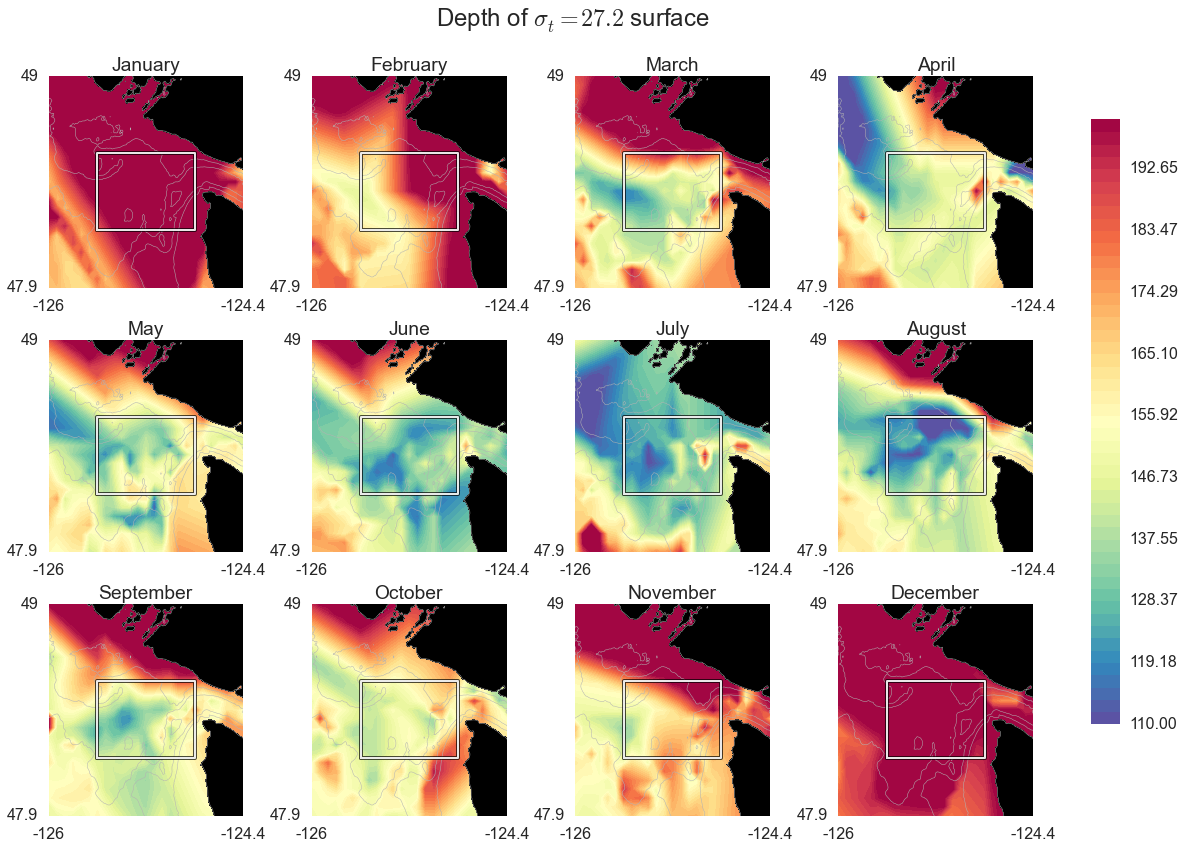

In [179]:
fig = plt.figure(figsize=(16,12))

for ii in range(1,13):
    plt.subplot(3,4,ii)
    im = draw_surface('ISOPYC',[k for k in filt_csts if k['Month'] == ii],27.2,'Depth',col_lim=(110,200),cmap='Spectral_r',show_cbar=False)
    plt.title(calendar.month_name[ii])

plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle(r'Depth of $\sigma_t = 27.2$ surface',fontsize=24)
plt.subplots_adjust(top=0.9)
plt.show()

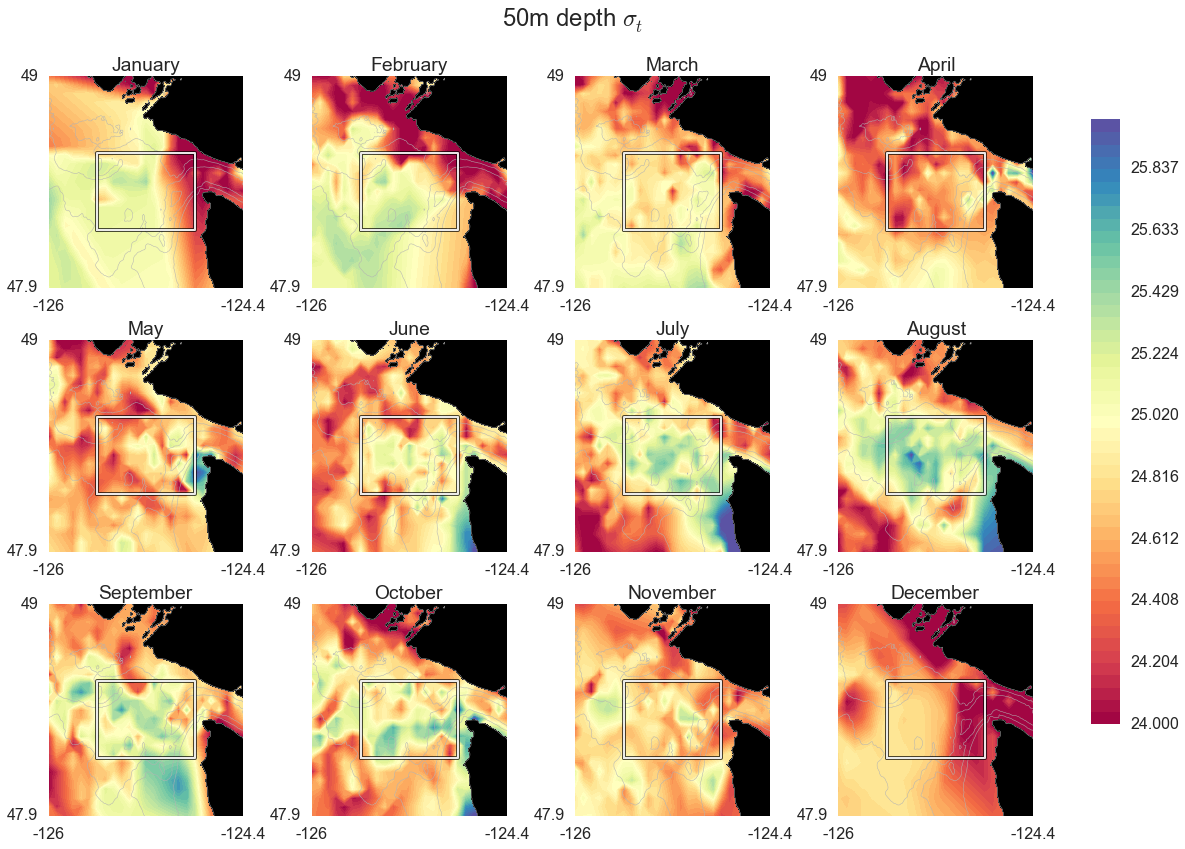

In [180]:
fig = plt.figure(figsize=(16,12))

for ii in range(1,13):
    plt.subplot(3,4,ii)
    im = draw_surface('DEPTH',[k for k in filt_csts if k['Month'] == ii],20,'sigmaT',col_lim=(24,26),cmap='Spectral',show_cbar=False)
    plt.title(calendar.month_name[ii])

plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle(r'50m depth $\sigma_t$',fontsize=24)
plt.subplots_adjust(top=0.9)
plt.show()

> using  84  cast data
> using  214  cast data
> using  267  cast data
> using  488  cast data
> using  826  cast data
> using  758  cast data
> using  705  cast data
> using  756  cast data
> using  592  cast data
> using  672  cast data
> using  236  cast data
> using  72  cast data


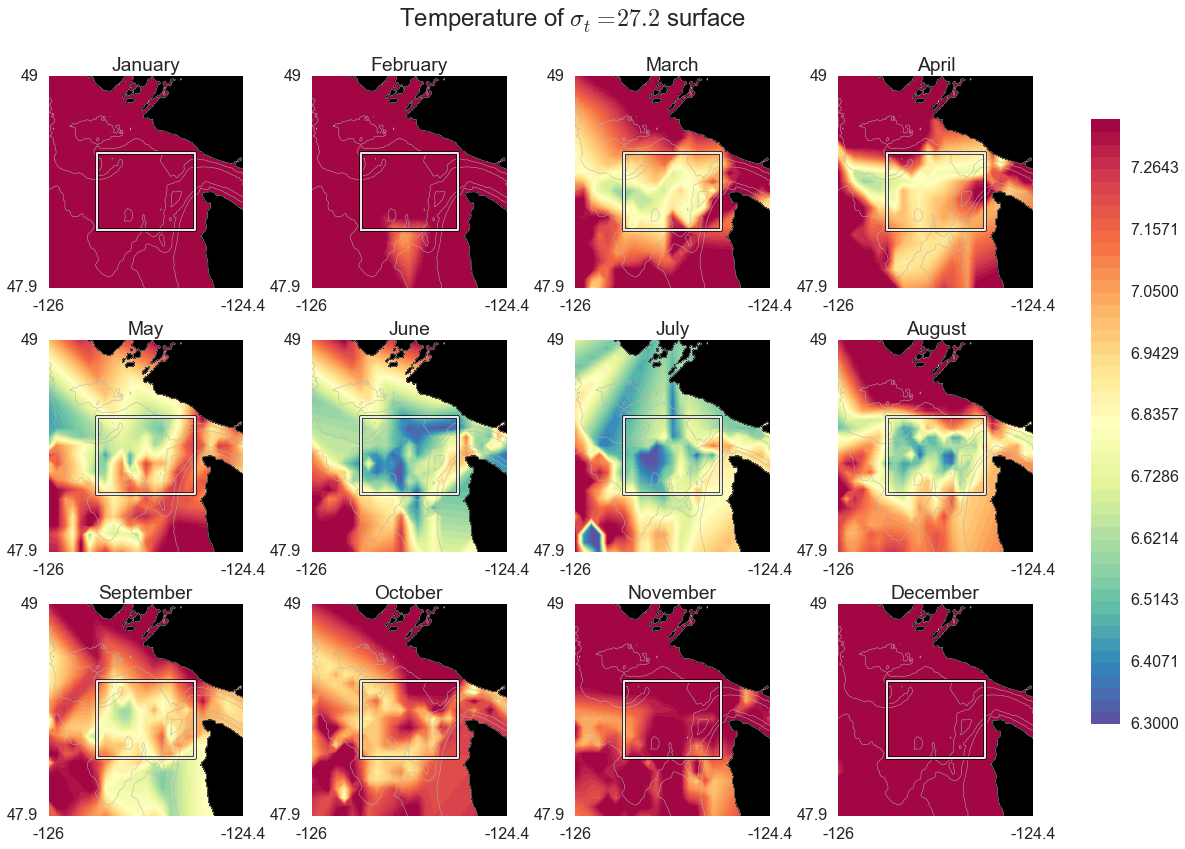

In [181]:
fig = plt.figure(figsize=(16,12))

for ii in range(1,13):
    plt.subplot(3,4,ii)
    im = draw_surface('ISOPYC',[k for k in filt_csts if k['Month'] == ii],27.2,'Temperature',col_lim=(6.3,7.35),cmap='Spectral_r',show_cbar=False)
    plt.title(calendar.month_name[ii])    

plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle(r'Temperature of $\sigma_t = 27.2$ surface',fontsize=24)
plt.subplots_adjust(top=0.9)
plt.show()

In [69]:
## The next set of cells is used to setup the annual cycle of depths, salinity, temperature for various sigma-t levels

%%capture --no-display

mn_dpths = {}
std_dpths = {}
#sig_lvls = np.linspace(26.5,27.2,7,endpoint=True)
#sig_lvls=[24.,25.25,26.5,26.94,26.95,27.2]
sig_lvls=[24.,25.3,26.5,27,27.2]
for ii in sig_lvls:
    mn_dpths[ii] = []
    std_dpths[ii] = []

for ii in range(1,13):
    cast_inf = [k for k in JdFE_csts if k['Month'] == ii]
    for jj in sig_lvls:
        (lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(cast_inf,jj,'Depth',JdFE_lon,JdFE_lat)
        if len(tmp) < 20:
            mn_dpths[jj].append(np.nan)
            std_dpths[jj].append(np.nan)
        else:
            mn_dpths[jj].append(-np.mean([k['Depth'] for k in tmp]))
            std_dpths[jj].append(np.std([k['Depth'] for k in tmp]))
        
#for jj in sig_lvls:
    #mn_dpths[jj].extend(mn_dpths[jj])
    #std_dpths[jj].extend(std_dpths[jj])

In [70]:
%%capture --no-display

mn_salns = {}
#sig_lvls = np.linspace(26.5,27.2,7,endpoint=True)
#sig_lvls=[24.,25.,26.5,26.94,26.95,27.2]
for ii in sig_lvls:
    mn_salns[ii] = []

for ii in range(1,13):
    cast_inf = [k for k in JdFE_csts if k['Month'] == ii]
    for jj in sig_lvls:
        (lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(cast_inf,jj,'Salinity',JdFE_lon,JdFE_lat)
        if len(tmp) < 20:
            mn_salns[jj].append(np.nan)
        else:
            mn_salns[jj].append(np.mean([k['Salinity'] for k in tmp]))
        
#for jj in sig_lvls:
    #mn_salns[jj].extend(mn_salns[jj])

In [71]:
%%capture --no-display

mn_temps = {}
#sig_lvls = np.linspace(26.5,27.2,7,endpoint=True)
#sig_lvls=[24.,25.,26.5,26.94,26.95,27.2]
for ii in sig_lvls:
    mn_temps[ii] = []

for ii in range(1,13):
    cast_inf = [k for k in JdFE_csts if k['Month'] == ii]
    for jj in sig_lvls:
        (lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(cast_inf,jj,'Temperature',JdFE_lon,JdFE_lat)
        if len(tmp) < 20:
            mn_temps[jj].append(np.nan)
        else:
            mn_temps[jj].append(np.mean([k['Temperature'] for k in tmp]))
        
#for jj in sig_lvls:
    #mn_temps[jj].extend(mn_temps[jj])

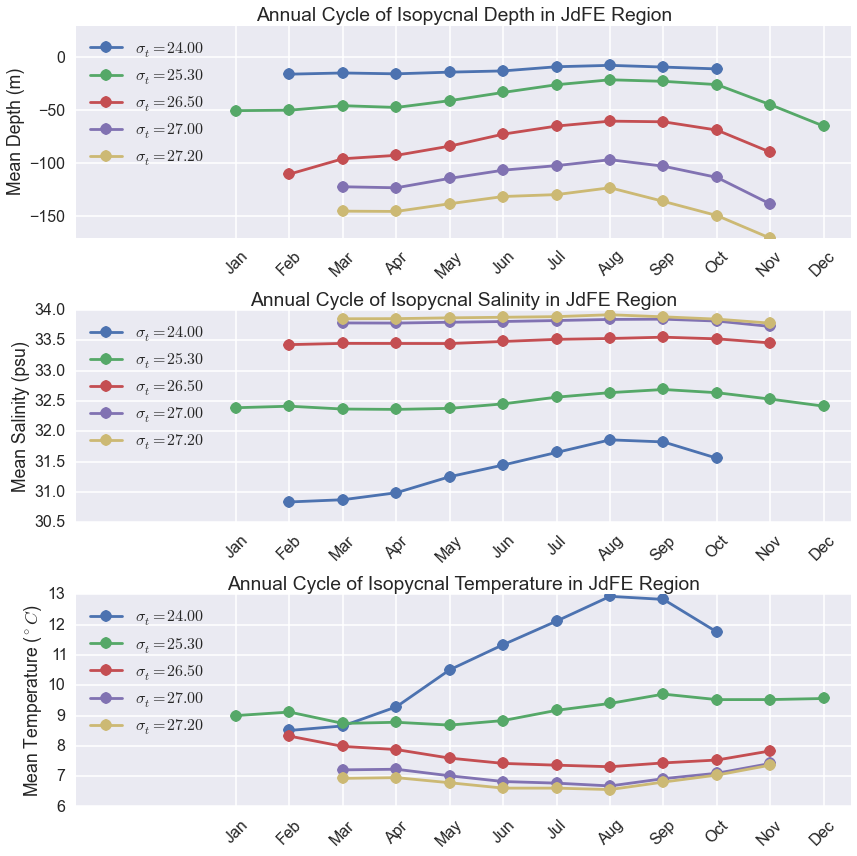

In [72]:
plt.figure(figsize=(12,12))        

plt.subplot(3,1,1)
for ii in sig_lvls:
    plt.plot(np.arange(1,13),mn_dpths[ii],'-o',label=r'$\sigma_t={0:.2f}$'.format(ii))
    #plt.fill_between(np.arange(1,25),np.array(mn_dpths[ii])-np.array(std_dpths[ii]),np.array(mn_dpths[ii])+np.array(std_dpths[ii]),alpha=0.3,color=[.2,.2,.2])

#plt.plot([12.5,13.5,13.5,12.5,12.5],[-260,-260,-160,-160,-260],'-k',lw=4,alpha=0.5)
#plt.plot([12.5,13.5,13.5,12.5,12.5],[-260,-260,-160,-160,-260],':w',lw=2,alpha=0.9)
    
plt.xlim((-2,12.5))
plt.ylim((-170,30))

tmp = calendar.month_abbr[1:]
#tmp.extend(tmp)

plt.xticks(np.arange(1,13),tmp,rotation=45)
plt.legend(loc=2)

plt.ylabel('Mean Depth (m)')
plt.title('Annual Cycle of Isopycnal Depth in JdFE Region')


'''
SALINITY
'''
plt.subplot(3,1,2)
for ii in sig_lvls:
    plt.plot(np.arange(1,13),mn_salns[ii],'-o',label=r'$\sigma_t={0:.2f}$'.format(ii))
    
plt.xlim((-2,12.5))

tmp = calendar.month_abbr[1:]
#tmp.extend(tmp)

plt.xticks(np.arange(1,13),tmp,rotation=45)
plt.legend(loc=2)

plt.ylabel('Mean Salinity (psu)')
plt.title('Annual Cycle of Isopycnal Salinity in JdFE Region')


'''
TEMPERATURE
'''
plt.subplot(3,1,3)



for ii in sig_lvls:
    tmp_temp = SW.ptmp(mn_salns[ii],mn_temps[ii],SW.pres(mn_dpths[ii],48))
    plt.plot(np.arange(1,13),tmp_temp,'-o',label=r'$\sigma_t={0:.2f}$'.format(ii))
    
plt.xlim((-2,12.5))

tmp = calendar.month_abbr[1:]
#tmp.extend(tmp)

plt.xticks(np.arange(1,13),tmp,rotation=45)
plt.legend(loc=2)

plt.ylabel(r'Mean Temperature ($^\circ C$)')
plt.title('Annual Cycle of Isopycnal Temperature in JdFE Region')

plt.tight_layout()
plt.show()

In [153]:
## these cells setup the sigma-t levels along the 48.5 parallel

sig_lvls=np.linspace(24.5,27.2,5,endpoint=True)#[24.,25.,26.,27]

# take 48.5N line transect

sig_dpths = np.zeros((12,len(sig_lvls),25))

for ii in range(1,13):
    for jj in range(0,len(sig_lvls)):
        (lon_region,lat_region,grid_dat,tmp)=TSmode.get_isopyc_surface([k for k in filt_csts if k['Month'] == ii],sig_lvls[jj],'Depth',LONrng,LATrng,Nlon=25,Nlat=10,interp='nearest')
        sig_dpths[ii-1,jj,:] = grid_dat[5,:]
        
lon_plt = lon_region[5,:]

> using  60  cast data
> using  84  cast data
> using  67  cast data
> using  39  cast data
> using  17  cast data
> using  217  cast data
> using  300  cast data
> using  231  cast data
> using  112  cast data
> using  52  cast data
> using  213  cast data
> using  365  cast data
> using  259  cast data
> using  172  cast data
> using  91  cast data
> using  603  cast data
> using  625  cast data
> using  480  cast data
> using  353  cast data
> using  174  cast data
> using  934  cast data
> using  978  cast data
> using  854  cast data
> using  639  cast data
> using  286  cast data
> using  747  cast data
> using  801  cast data
> using  711  cast data
> using  572  cast data
> using  321  cast data
> using  717  cast data
> using  766  cast data
> using  693  cast data
> using  510  cast data
> using  265  cast data
> using  683  cast data
> using  747  cast data
> using  670  cast data
> using  555  cast data
> using  266  cast data
> using  502  cast data
> using  628  cast data

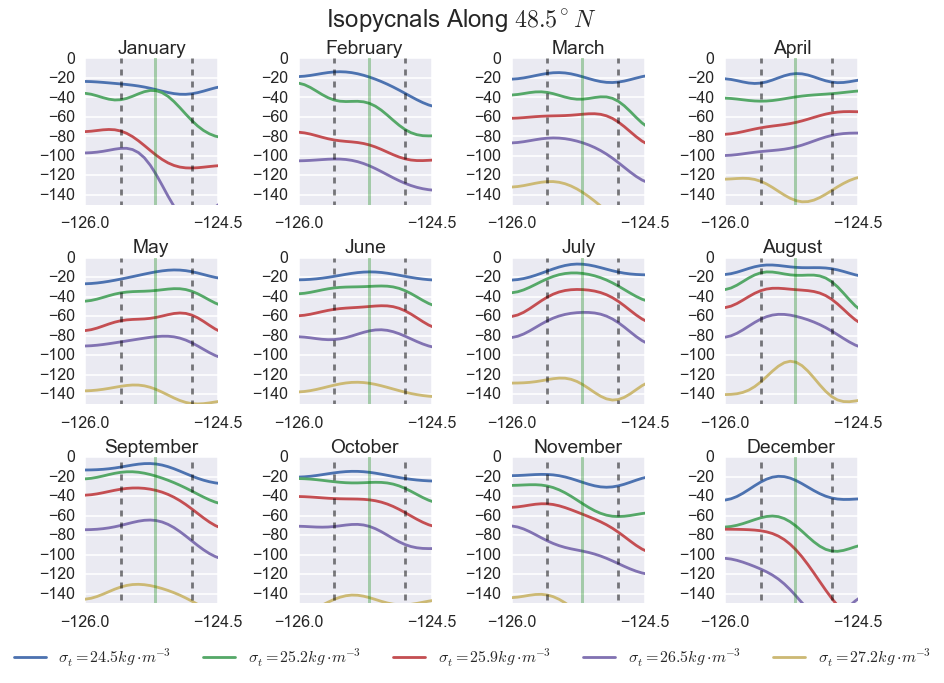

In [166]:
plt.figure(figsize=(12,9))

sig_filt = np.zeros_like(sig_dpths)

for ii in range(0,12):
    for jj in range(0,len(sig_lvls)):
        ext_ln = np.squeeze(sig_dpths[ii,jj,:])
        ext_ln = np.append(ext_ln,np.squeeze(sig_dpths[ii,jj,::-1]))
        ext_hat = np.fft.fft(ext_ln)
        
        Nwave_nums = 3
        ext_hat[Nwave_nums:-(Nwave_nums+1)] = 0
        ext_filt = np.real(np.fft.ifft(ext_hat))
        sig_filt[ii,jj,:] = ext_filt[0:25]

for ii in range(1,13):
    ax = plt.subplot(3,4,ii)
    for jj in range(0,len(sig_lvls)):
        plt.plot(lon_plt,-sig_filt[ii-1,jj,:],label=r'$\sigma_t={0:.1f}$'.format(sig_lvls[jj])+r'$kg \cdot m^{-3}$')
        
    plt.plot([JdFE_lon[0],JdFE_lon[0]],[-300,0],'--k',alpha=0.5)
    plt.plot([JdFE_lon[1],JdFE_lon[1]],[-300,0],'--k',alpha=0.5)
    
    plt.plot([-(125+12.5/60.0),-(125+12.5/60.0)],[-300,0],'-g',alpha=0.3,lw=3)
    plt.ylim((-150,0))
    plt.xlim((-126,-124.5))
    plt.xticks((-126,-124.5))
    plt.title(calendar.month_name[ii])
    
ax.legend(loc='lower center', bbox_to_anchor=(-1.9, -0.55),ncol=5, fancybox=True, shadow=True)

plt.tight_layout()
plt.suptitle(r'Isopycnals Along $48.5 ^\circ N$',fontsize=24)
plt.subplots_adjust(top=0.9)
plt.show()

Okay, here we get into using spice. I took this code from the seawater extended toolbox (found on google). Not comfortable working with spice/using this function. Needs work.

In [ ]:
def get_spice(s, t, d, lat):
    """Compute sea spiciness as defined by Flament (2002).
    .. math:: \pi(\theta,s) = \sum^5_{i=0} \sum^4_{j=0} b_{ij}\theta^i(s-35)^i
    Parameters
    ----------
    s(p) : array_like
           salinity [psu (PSS-78)]
    t(p) : array_like
           temperature [:math:`^\\circ` C (ITS-90)]
    p : array_like
        pressure [db]
    Returns
    -------
    sp : array_like
         :math:`\pi` [kg m :sup:`3`]
    See Also
    --------
    pressure is not used... should the input be theta instead of t?
    Go read the paper!
    Notes
    -----
    Spiciness, just like potential density, is only useful over limited
    vertical excursions near the pressure to which they are referenced; for
    large vertical ranges, the slope of the isopycnals and spiciness isopleths
    vary significantly with pressure, and generalization of the polynomial
    expansion to include a reference pressure dependence is needed.
    Examples
    --------
    >>> from oceans import sw_extras as swe
    >>> swe.spice(33, 15, 0)
    array(0.5445864137500002)
    References
    ----------
    .. [1] A state variable for characterizing water masses and their
    diffusive stability: spiciness. Prog. in Oceanography Volume 54, 2002,
    Pages 493-501.
    http://www.satlab.hawaii.edu/spice/spice.m
    Modifications: 2011/03/15. Filipe Fernandes, python translation.
    """
    p = SW.pres(d,lat)
    
    s, t, p = list(map(np.asanyarray, (s, t, p)))
    # FIXME: I'm not sure about this.
    pt = SW.ptmp(s, t, p)

    B = np.zeros((6, 5))
    B[0, 0] = 0.
    B[0, 1] = 7.7442e-001
    B[0, 2] = -5.85e-003
    B[0, 3] = -9.84e-004
    B[0, 4] = -2.06e-004

    B[1, 0] = 5.1655e-002
    B[1, 1] = 2.034e-003
    B[1, 2] = -2.742e-004
    B[1, 3] = -8.5e-006
    B[1, 4] = 1.36e-005

    B[2, 0] = 6.64783e-003
    B[2, 1] = -2.4681e-004
    B[2, 2] = -1.428e-005
    B[2, 3] = 3.337e-005
    B[2, 4] = 7.894e-006

    B[3, 0] = -5.4023e-005
    B[3, 1] = 7.326e-006
    B[3, 2] = 7.0036e-006
    B[3, 3] = -3.0412e-006
    B[3, 4] = -1.0853e-006

    B[4, 0] = 3.949e-007
    B[4, 1] = -3.029e-008
    B[4, 2] = -3.8209e-007
    B[4, 3] = 1.0012e-007
    B[4, 4] = 4.7133e-008

    B[5, 0] = -6.36e-010
    B[5, 1] = -1.309e-009
    B[5, 2] = 6.048e-009
    B[5, 3] = -1.1409e-009
    B[5, 4] = -6.676e-010

    sp = np.zeros_like(pt)
    T = np.ones_like(pt)
    s -= 35
    r, c = B.shape
    for i in range(r):
        S = np.ones_like(pt)
        for j in range(c):
            sp += B[i, j] * T * S
            S *= s
        T *= pt

    return sp


In [ ]:
%%capture --no-display

mn_spice = {}
#sig_lvls = np.linspace(26.5,27.2,7,endpoint=True)
sig_lvls=[24.,25.0,26.5,26.94,26.95,27.2]
for ii in sig_lvls:
    mn_spice[ii] = []

for ii in range(1,13):
    cast_inf = [k for k in JdFE_csts if k['Month'] == ii]
    for jj in sig_lvls:
        (lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(cast_inf,jj,'Temperature',JdFE_lon,JdFE_lat)
        T = np.mean([k['Temperature'] for k in tmp])
        lat = np.mean([k['Latitude'] for k in tmp])
        (lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(cast_inf,jj,'Salinity',JdFE_lon,JdFE_lat)
        S = np.mean([k['Salinity'] for k in tmp])
        (lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(cast_inf,jj,'Depth',JdFE_lon,JdFE_lat)
        D = np.mean([k['Depth'] for k in tmp])
        mn_spice[jj].append(get_spice(S,T,D,lat))
        
#for jj in sig_lvls:
    #mn_spice[jj].extend(mn_spice[jj])

In [ ]:
plt.figure(figsize=(12,6))

for ii in sig_lvls:
    plt.plot(np.arange(1,13),(np.array(mn_spice[ii])-np.mean(mn_spice[ii]))/np.max(np.abs(mn_spice[ii]-np.mean(mn_spice[ii]))),'-o',label=r'$\sigma_t={0:.2f}$'.format(ii))
    
plt.xlim((-2,12.5))

tmp = calendar.month_abbr[1:]
#tmp.extend(tmp)

plt.xticks(np.arange(1,13),tmp,rotation=45)
plt.legend(loc=2)

plt.ylabel(r'Mean Spice ($\pi$)')
plt.title('Normalized Annual Cycle of Isopycnal Spice in JdFE Region (Relative to Mean Annual Spice)')

plt.tight_layout()
plt.show()


Now: track the $\sigma_t = 27.2$ water.

In [ ]:
for ii in range(1,13):
    cast_inf = [k for k in JdFE_csts if k['Month'] == ii]
    (lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(cast_inf,27.2,'Salinity',JdFE_lon,JdFE_lat)
    S = np.mean([k['Salinity'] for k in tmp])
    (lon_region,lat_region,grid_dat,tmp) = TSmode.get_isopyc_surface(cast_inf,27.2,'Temperature',JdFE_lon,JdFE_lat)
    T = np.mean([k['Temperature'] for k in tmp])
    
    for cc in [j for j in filt_csts if j['Month'] == ii]:
        cc['EddyWater'] = np.zeros(len(cc['Depth']))
        for jj in range(0,len(cc['Depth'])):
            Teps = 0.1
            Seps = 0.1
            sigeps = 0.1
            if np.abs(cc['Temperature'][jj]-T) <= Teps and np.abs(cc['Salinity'][jj]-S) <= Seps and np.abs(cc['sigmaT'][jj]-27.2) <=sigeps:
                cc['EddyWater'][jj] = 1

In [ ]:
plt.figure(figsize=(12,12))
for ii in range(1,13):
    plt.subplot(3,4,ii)
    plt.plot([k['Longitude'] for k in filt_csts if k['Month'] == ii],[k['Latitude'] for k in filt_csts if k['Month'] == ii],'.k',ms=2,alpha=0.3)
    
    EWcsts = [k for k in filt_csts if k['Month'] == ii and np.sum(k['EddyWater']) > 0]
    EWlons = [k['Longitude'] for k in EWcsts]
    EWlats = [k['Latitude'] for k in EWcsts]
    
    EWdpth = []
    for cc in EWcsts:
        for jj in range(0,len(cc['Depth'])):
            if cc['EddyWater'][jj] == 1:
                EWdpth.append(cc['Depth'][jj])
                break
                
    for jj in range(0,len(EWcsts)):
        plt.plot(EWlons[jj],EWlats[jj],'o',ms=4,color=(1.0-(EWdpth[jj]-np.min(EWdpth))/(np.max(EWdpth)-np.min(EWdpth)))*np.array([0,1,0]))
    plt.xticks(LONrng,[str(LONrng[0]),str(LONrng[1])])
    plt.yticks(LATrng,[str(LATrng[0]),str(LATrng[1])])
    plt.title(calendar.month_name[ii])

plt.tight_layout()
plt.show()

This code is starting to work with bathymetry -- starting point for geostrophic currents stuff. Needs lots of work.

In [50]:
def depths_region(lonvals,latvals):
    dpths = []
    for ii,row in enumerate(wcvi_top['topo']):
        for jj,val in enumerate(row):
            if wcvi_top['lons'][ii,jj] >= lonvals[0] and wcvi_top['lons'][ii,jj] <= lonvals[1] and \
                wcvi_top['lats'][ii,jj] >= latvals[0] and wcvi_top['lats'][ii,jj] <= latvals[1]:
                dpths.append(wcvi_top['topo'][ii,jj])
    return dpths

In [51]:
dpths = depths_region(JdFE_lon,JdFE_lat)

print 'Mean dpth: ', str(np.mean(dpths))
print 'Min dpth : ', str(np.min(dpths))
print 'Max dpth : ', str(np.max(dpths))

Mean dpth:  -142.599091493
Min dpth :  -332.553753954
Max dpth :  -31.3503649635


In [41]:
reload(TSmode)

<module 'TSmode' from 'TSmode.py'>